<a href="https://colab.research.google.com/github/andersenthomas98/timeseries-forecasting/blob/main/Autogluon_climate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas autogluon.timeseries kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.5/120.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.1/229.1 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.0/306.0 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [3]:
from google.colab import userdata
from kaggle.api.kaggle_api_extended import KaggleApi
import os

# Setup environment variables for authenticating to kaggle using the kaggle API
kaggleUsername = userdata.get("KAGGLE_USERNAME")
kaggleKey = userdata.get("KAGGLE_KEY")
os.environ["KAGGLE_USERNAME"] = kaggleUsername
os.environ["KAGGLE_KEY"] = kaggleKey

# Authenticate
api = KaggleApi()
api.authenticate()

# Download dataset
datasetName = "sumanthvrao/daily-climate-time-series-data"
datasetPath = "/content/climate"
api.dataset_download_files(datasetName, path=datasetPath, unzip=True)

In [4]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [103]:
filePathTrain = "{}/DailyDelhiClimateTrain.csv".format(datasetPath)
print(filePathTrain)

df_wide = pd.read_csv(filePathTrain, index_col=0, parse_dates=True)

# Remove the first row if it contains inaccurate data for mean pressure
df_wide = df_wide.iloc[1:]

# Ensure all numerical columns are float32
for col in df_wide.columns:
    if df_wide[col].dtype != "object" and not pd.api.types.is_string_dtype(df_wide[col]):
        df_wide[col] = df_wide[col].astype("float32")

print(df_wide.head())  # Changed to head for brevity
print(df_wide.dtypes)
print(df_wide.index.dtype)

# Convert wide dataframe to long
df_long = pd.melt(df_wide.reset_index(), id_vars=['date'], var_name='item_id', value_name='target')

df_long['date'] = pd.to_datetime(df_long['date'])

print(df_long.head())
print(df_long.dtypes)
print(df_long.index.dtype)

/content/climate/DailyDelhiClimateTrain.csv
            meantemp   humidity  wind_speed  meanpressure
date                                                     
2013-01-02  7.400000  92.000000    2.980000   1017.799988
2013-01-03  7.166667  87.000000    4.633333   1018.666687
2013-01-04  8.666667  71.333336    1.233333   1017.166687
2013-01-05  6.000000  86.833336    3.700000   1016.500000
2013-01-06  7.000000  82.800003    1.480000   1018.000000
meantemp        float32
humidity        float32
wind_speed      float32
meanpressure    float32
dtype: object
datetime64[ns]
        date   item_id    target
0 2013-01-02  meantemp  7.400000
1 2013-01-03  meantemp  7.166667
2 2013-01-04  meantemp  8.666667
3 2013-01-05  meantemp  6.000000
4 2013-01-06  meantemp  7.000000
date       datetime64[ns]
item_id            object
target            float32
dtype: object
int64


In [104]:
train_data = TimeSeriesDataFrame.from_data_frame(df_long, id_column="item_id", timestamp_column="date")
train_data.head()

target
item_id  timestamp           
meantemp 2013-01-02  7.400000
         2013-01-03  7.166667
         2013-01-04  8.666667
         2013-01-05  6.000000
         2013-01-06  7.000000

In [123]:
predictor = TimeSeriesPredictor(
    prediction_length=90,
    path="autogluon-climate-daily",
    target="target",
    eval_metric="MAPE",
    cache_predictions=False
)

predictor.fit(train_data, presets="best_quality", time_limit=1200)

Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to 'autogluon-climate-daily'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
CPU Count:          2
GPU Count:          1
Memory Avail:       8.53 GB / 12.67 GB (67.3%)
Disk Space Avail:   45.00 GB / 78.19 GB (57.6%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 90,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': 'target',
 'time_limit': 1200,
 'verbosity': 2}

Inferred time series frequency: 'D'
Provided train_data has 5844 rows, 4 time series. Median time series le

In [125]:
filePathTest = "{}/DailyDelhiClimateTest.csv".format(datasetPath)
print(filePathTest)

df_wide_test = pd.read_csv(filePathTest, index_col=0, parse_dates=True)

# Remove the first row if it contains inaccurate data for mean pressure
df_wide_test = df_wide_test.iloc[1:]

# Ensure all numerical columns are float32
for col in df_wide_test.columns:
    if df_wide_test[col].dtype != "object" and not pd.api.types.is_string_dtype(df_wide_test[col]):
        df_wide_test[col] = df_wide_test[col].astype("float32")

print(df_wide_test.head())  # Changed to head for brevity
print(df_wide_test.dtypes)
print(df_wide_test.index.dtype)

# Convert wide dataframe to long
df_long_test = pd.melt(df_wide_test.reset_index(), id_vars=['date'], var_name='item_id', value_name='target')

df_long_test['date'] = pd.to_datetime(df_long_test['date'])

print(df_long_test.head())
print(df_long_test.dtypes)
print(df_long_test.index.dtype)

/content/climate/DailyDelhiClimateTest.csv
             meantemp   humidity  wind_speed  meanpressure
date                                                      
2017-01-02  18.500000  77.222221    2.894444   1018.277771
2017-01-03  17.111111  81.888885    4.016667   1018.333313
2017-01-04  18.700001  70.050003    4.545000   1015.700012
2017-01-05  18.388889  74.944443    3.300000   1014.333313
2017-01-06  19.318182  79.318184    8.681818   1011.772705
meantemp        float32
humidity        float32
wind_speed      float32
meanpressure    float32
dtype: object
datetime64[ns]
        date   item_id     target
0 2017-01-02  meantemp  18.500000
1 2017-01-03  meantemp  17.111111
2 2017-01-04  meantemp  18.700001
3 2017-01-05  meantemp  18.388889
4 2017-01-06  meantemp  19.318182
date       datetime64[ns]
item_id            object
target            float32
dtype: object
int64


In [126]:
test_data = TimeSeriesDataFrame.from_data_frame(df_long_test, id_column="item_id", timestamp_column="date")
predictions = predictor.predict(train_data, use_cache=False)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean        0.1        0.2  ...        0.7        0.8        0.9
item_id  timestamp                                    ...                                 
meantemp 2017-01-02  14.195906  10.919303  11.945295  ...  15.807722  16.694824  17.635674
         2017-01-03  14.651749  10.507206  11.884636  ...  16.496124  17.572800  18.840504
         2017-01-04  14.736639  10.565500  11.985247  ...  16.503376  17.581982  18.860611
         2017-01-05  15.111710  10.248005  11.958380  ...  17.065144  18.318712  19.865477
         2017-01-06  14.649087  10.400476  11.916338  ...  16.300449  17.417103  18.764702

[5 rows x 10 columns]

In [120]:
predictions.loc["meantemp"]["mean"]

timestamp
2017-01-02    10.937409
2017-01-03    10.922402
2017-01-04    10.897843
2017-01-05    10.880045
2017-01-06    10.871661
2017-01-07    10.870258
2017-01-08    10.874119
2017-01-09    10.881531
2017-01-10    10.876009
2017-01-11    10.871359
2017-01-12    10.867977
2017-01-13    10.866890
2017-01-14    10.868769
2017-01-15    10.873844
2017-01-16    10.880732
2017-01-17    10.875469
2017-01-18    10.870826
2017-01-19    10.867439
2017-01-20    10.866311
2017-01-21    10.868116
2017-01-22    10.873086
2017-01-23    10.879987
2017-01-24    10.874821
2017-01-25    10.870292
2017-01-26    10.867016
2017-01-27    10.865978
2017-01-28    10.867844
2017-01-29    10.872848
2017-01-30    10.879870
2017-01-31    10.874800
Name: mean, dtype: float64

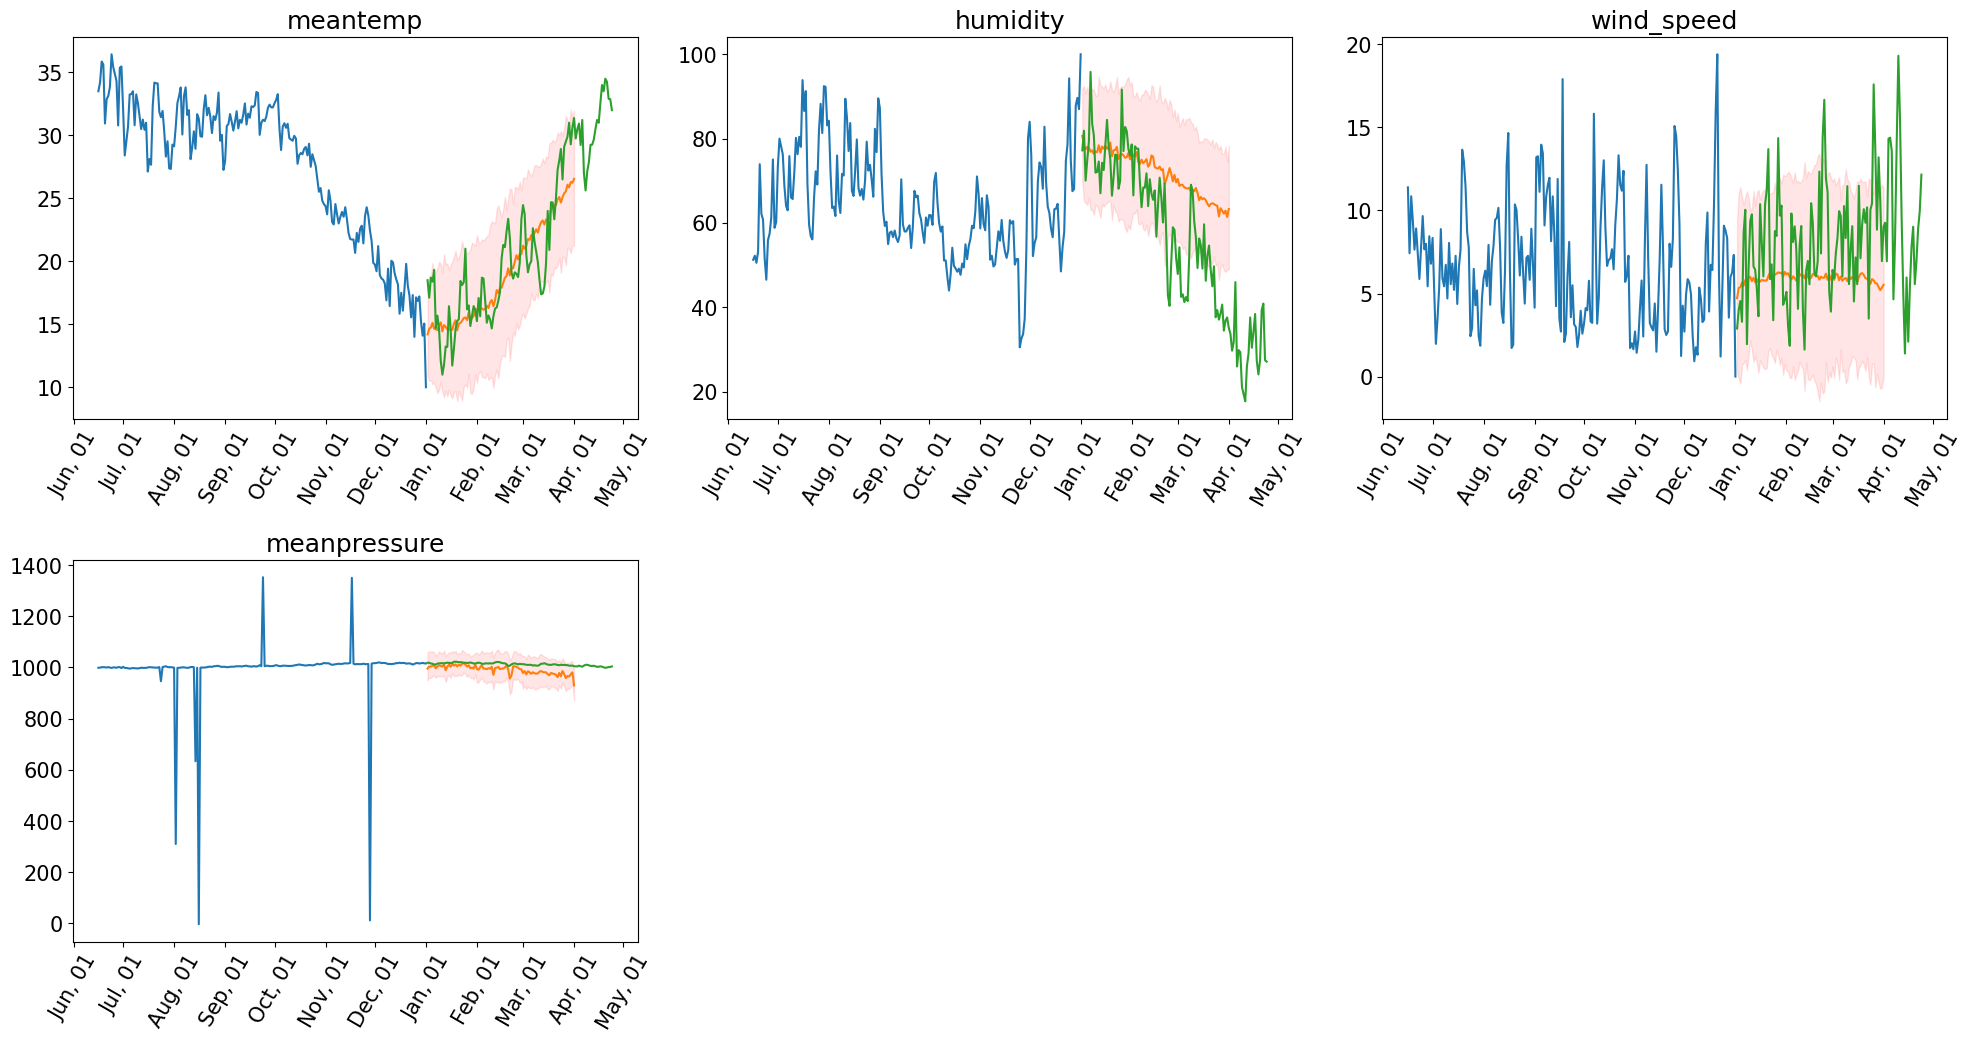

In [127]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
item_ids = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']

plt.figure(figsize=(20,15))

date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, item_id in enumerate(item_ids):

    ax = plt.subplot(3,3, idx+1)
    y_past = train_data.loc[item_id][-200:]
    y_pred = predictions.loc[item_id]
    y_test = test_data.loc[item_id]

    # Past time series values
    ax.plot(y_past.index, y_past.values, label="Past time series values")
    # Mean forecast
    ax.plot(y_pred.index, y_pred['mean'], label="Mean forecast")
    # Future time series values
    ax.plot(y_test.index, y_test.values, label="Future time series values")

    # Filling between the confidence intervals
    ax.fill_between(y_pred.index, y_pred['0.1'], y_pred['0.9'], color="red", alpha=0.1, label="10%-90% confidence interval")

    ax.set_title(item_id)

    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()

plt.show()

In [122]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,Theta,-0.946732,-1.694218,0.060925,0.920393,0.016405,4
1,WeightedEnsemble,-1.139846,-0.714705,1.103274,4.809626,1.270929,8
2,Naive,-1.152873,-0.721732,0.029794,0.021793,0.024427,1
3,ETS,-1.168936,-0.786959,0.944204,4.752164,0.016831,3
4,TemporalFusionTransformer,-1.176144,-0.784078,0.125539,0.035668,67.473867,7
5,RecursiveTabular,-1.241086,-3.368880,0.452725,0.515092,3.012856,5
6,SeasonalNaive,-1.483781,-3.362660,0.026056,0.019014,0.014533,2
7,DirectTabular,-2.810340,-1.241877,0.123803,0.090733,2.413763,6
